In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

## Data Extraction

In [4]:
loans_df = pd.read_csv('loan.csv',encoding='utf-8')

/Users/aarora7/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Cleaning

In [5]:
#Check if there any columns, with all rows null. Remove such columns
loans_df = loans_df.dropna(how='all',axis=1)

In [6]:
#Check if there are columns with lots of data missing
(loans_df.isnull().sum(axis = 0)/len(loans_df)*100).sort_values(ascending=False)

next_pymnt_d                  97.129693
mths_since_last_record        92.985372
mths_since_last_delinq        64.662487
desc                          32.580507
emp_title                      6.191303
emp_length                     2.706650
pub_rec_bankruptcies           1.754916
last_pymnt_d                   0.178765
chargeoff_within_12_mths       0.140998
collections_12_mths_ex_med     0.140998
revol_util                     0.125891
tax_liens                      0.098195
title                          0.027696
last_credit_pull_d             0.005036
collection_recovery_fee        0.000000
acc_now_delinq                 0.000000
application_type               0.000000
url                            0.000000
pymnt_plan                     0.000000
loan_status                    0.000000
issue_d                        0.000000
verification_status            0.000000
annual_inc                     0.000000
home_ownership                 0.000000
delinq_amnt                    0.000000


In [7]:
'''
next_pymnt_d               97.129693
mths_since_last_record     92.985372
mths_since_last_delinq     64.662487
'''
#It is observed that these columns have a large amount of data missing, so we can safely remove these
loans_df = loans_df.drop(['mths_since_last_delinq','mths_since_last_record','next_pymnt_d'], axis=1)                     

In [8]:
#Check if there are columns with just 1, or 2(null included) unique value, which makes them useless
for col in loans_df.columns:
    unique_vals = loans_df[col].unique()
    num_uniques = len(unique_vals)
    if num_uniques <= 2:
        print (col, unique_vals)

term [' 36 months' ' 60 months']
pymnt_plan ['n']
initial_list_status ['f']
collections_12_mths_ex_med [ 0. nan]
policy_code [1]
application_type ['INDIVIDUAL']
acc_now_delinq [0]
chargeoff_within_12_mths [ 0. nan]
delinq_amnt [0]
tax_liens [ 0. nan]


#### Removing the following columns, since they don't contribute to any variance
pymnt_plan ['n']
initial_list_status ['f']
collections_12_mths_ex_med [ 0. nan]
policy_code [1]
application_type ['INDIVIDUAL']
acc_now_delinq [0]
chargeoff_within_12_mths [ 0. nan]
delinq_amnt [0]
tax_liens [ 0. nan]

In [9]:
loans_df = loans_df.drop(['pymnt_plan','initial_list_status','policy_code','delinq_amnt','acc_now_delinq','application_type','collections_12_mths_ex_med','chargeoff_within_12_mths','tax_liens'], axis=1)

#### Remove columns that are extremely correlated from each other

In [10]:
threshold = 0.98
# Create correlation matrix
corr_matrix = loans_df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

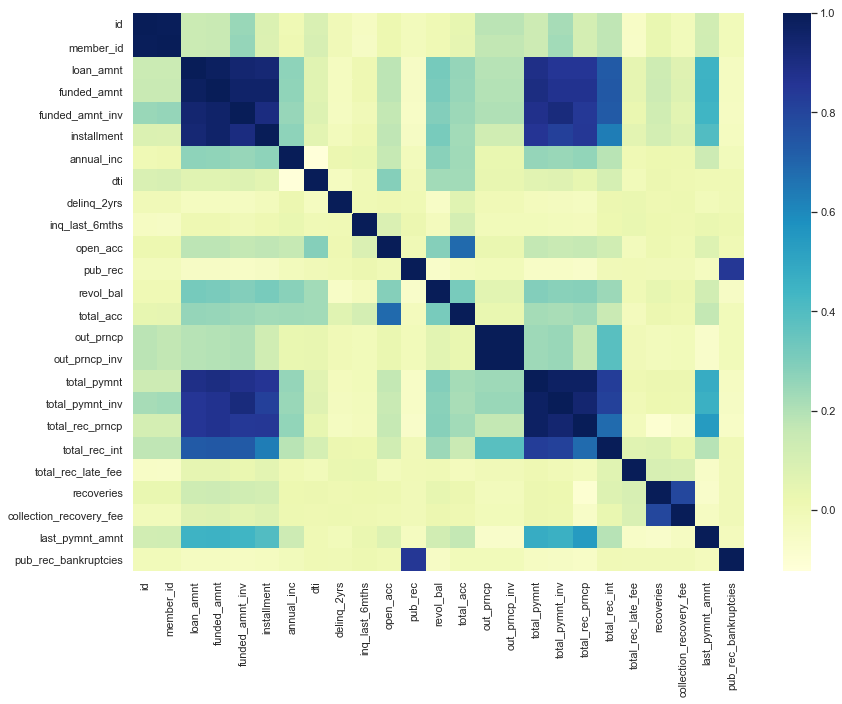

In [11]:
#Correlation heatmap
sns.set(rc={'figure.figsize':(13.7,10.27)})
sns.heatmap(loans_df.corr(), vmax=1., square=False , cmap="YlGnBu")
plt.show()

In [12]:
##Redundant columns 'member_id', 'funded_amnt', 'out_prncp_inv' since they are very
##highly correlated with 'id', loan_amnt, out_prncp
loans_df = loans_df.drop(to_drop, axis=1)

In [13]:
#Final loan_df shape
print(loans_df.shape)

(39717, 42)


In [14]:
loans_df.columns

Index(['id', 'loan_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment',
       'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'url',
       'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'pub_rec_bankruptcies'],
      dtype='object')

In [15]:
#wrote filtered columns in a file
#for convenience 
dd= pd.read_csv('dd.csv')
dd[dd['LoanStatNew'].isin(loans_df.columns)].to_csv('fdd.csv', sep=',')

### Attribute Analysis

In [16]:
loans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 42 columns):
id                         39717 non-null int64
loan_amnt                  39717 non-null int64
funded_amnt_inv            39717 non-null float64
term                       39717 non-null object
int_rate                   39717 non-null object
installment                39717 non-null float64
grade                      39717 non-null object
sub_grade                  39717 non-null object
emp_title                  37258 non-null object
emp_length                 38642 non-null object
home_ownership             39717 non-null object
annual_inc                 39717 non-null float64
verification_status        39717 non-null object
issue_d                    39717 non-null object
loan_status                39717 non-null object
url                        39717 non-null object
desc                       26777 non-null object
purpose                    39717 non-null object
title   

#### Interest Rate

In [20]:
#Checking for interest rate. Does it remain similar, or if it has high variance.
#Higher interest rate loans might be difficult to pay off.
loans_df.int_rate.head()

0    10.65%
1    15.27%
2    15.96%
3    13.49%
4    12.69%
Name: int_rate, dtype: object

In [22]:
#Removing % sign and convert all to float
loans_df.int_rate = loans_df.int_rate.map(lambda x: float(x.replace("%","")))

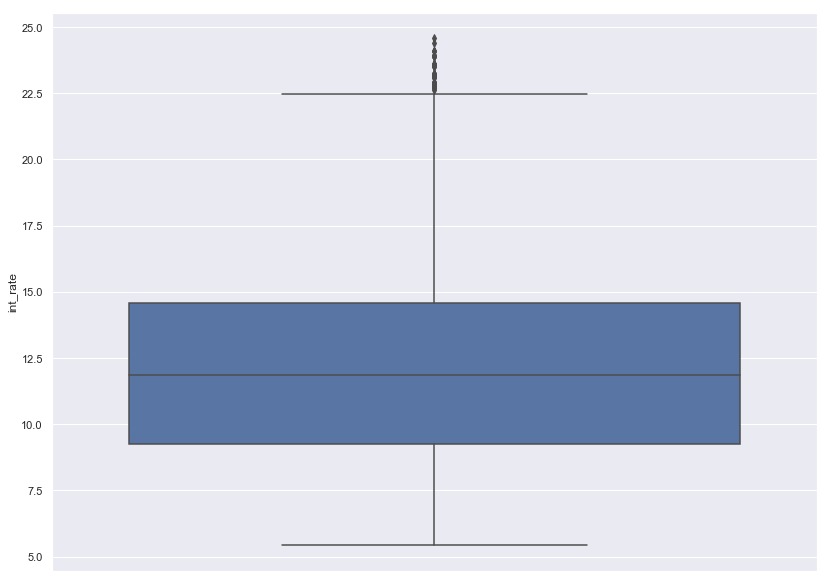

In [24]:
ax = sns.boxplot(y=loans_df.int_rate)

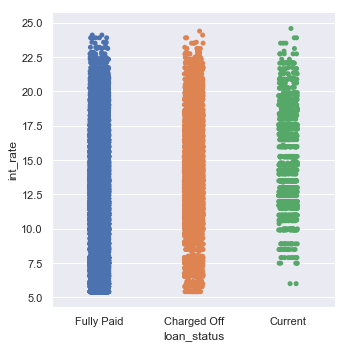

In [33]:
#It is clear that while most interest rates are between 9 and 14, there is a huge variance. Hence this can be a interesting parameter for analyisis
#Checking against loan_default_status
sns.catplot(x="loan_status", y="int_rate", data=loans_df);

In [34]:
#However, from the scatter plot we cannot say if interest rate is very affective to find if loan will default

#### Purpose

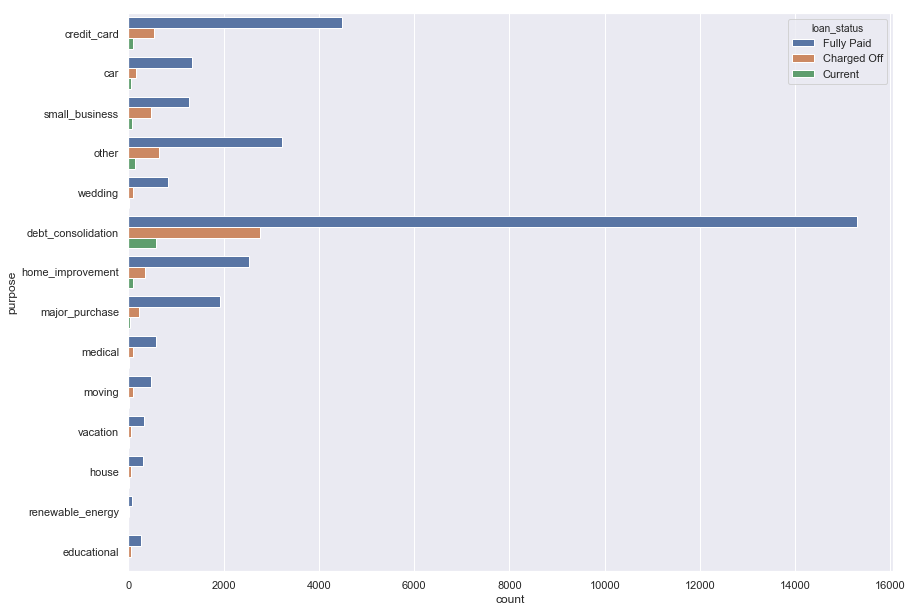

In [31]:
#Since this is a text column. Checking categories via a histplot
ax = sns.countplot(y="purpose", hue="loan_status", data=loans_df)

In [38]:
#Plotting Percentage of default loans (default/ default+fully paid) for each purpose
loans_purpose_df = loans_df[['id','purpose','loan_status']]
loans_purpose_pivot_df =loans_df.pivot_table(index='purpose',columns='loan_status', values='id',aggfunc='count',fill_value=0)
loans_purpose_pivot_df['default_ratio_loanscompleted%'] = (loans_purpose_pivot_df['Charged Off']/(loans_purpose_pivot_df['Fully Paid']+ loans_purpose_pivot_df['Charged Off']))*100
loans_purpose_pivot_df.sort_values(by='default_ratio_loanscompleted%', inplace=True, ascending=False)


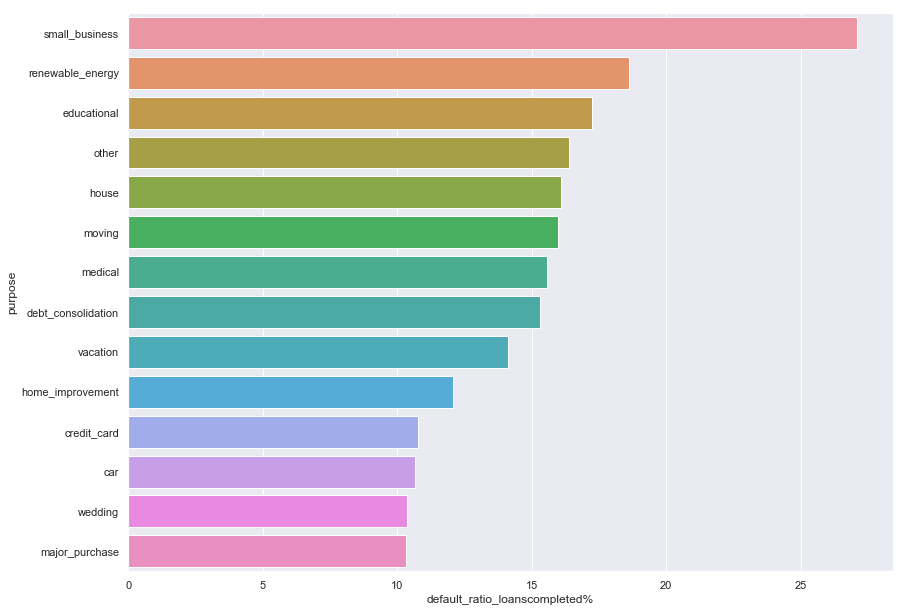

In [50]:
.head()
#loans_purpose_pivot_df.purpose.head()
ax = sns.barplot(y=loans_purpose_pivot_df.index, x="default_ratio_loanscompleted%", data=loans_purpose_pivot_df)


#### Ordinal Variable Analysis

In [61]:
loans_df.columns

Index(['id', 'loan_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment',
       'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'url',
       'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'pub_rec_bankruptcies'],
      dtype='object')

In [66]:
#Similar analysis for all ordinal variables
ordinal_variables = ['term','purpose', 'zip_code','grade','sub_grade']
loans_ordinal_pivot_df_arr = {}
min_loans = 5
for ordinal in ordinal_variables:
    loans_ordinal_df = loans_df[['id',ordinal,'loan_status']]
    loans_ordinal_pivot_df =loans_df.pivot_table(index=ordinal,columns='loan_status', values='id',aggfunc='count',fill_value=0)
    loans_ordinal_pivot_df['default_ratio_loanscompleted%'] = (loans_ordinal_pivot_df['Charged Off']/(loans_ordinal_pivot_df['Fully Paid']+ loans_ordinal_pivot_df['Charged Off']))*100
    loans_ordinal_pivot_df.sort_values(by='default_ratio_loanscompleted%', inplace=True, ascending=False)
    loans_ordinal_pivot_df = loans_ordinal_pivot_df.loc[loans_ordinal_pivot_df['Charged Off']+loans_ordinal_pivot_df['Fully Paid']>min_loans]
    loans_ordinal_pivot_df_arr[ordinal]= loans_ordinal_pivot_df


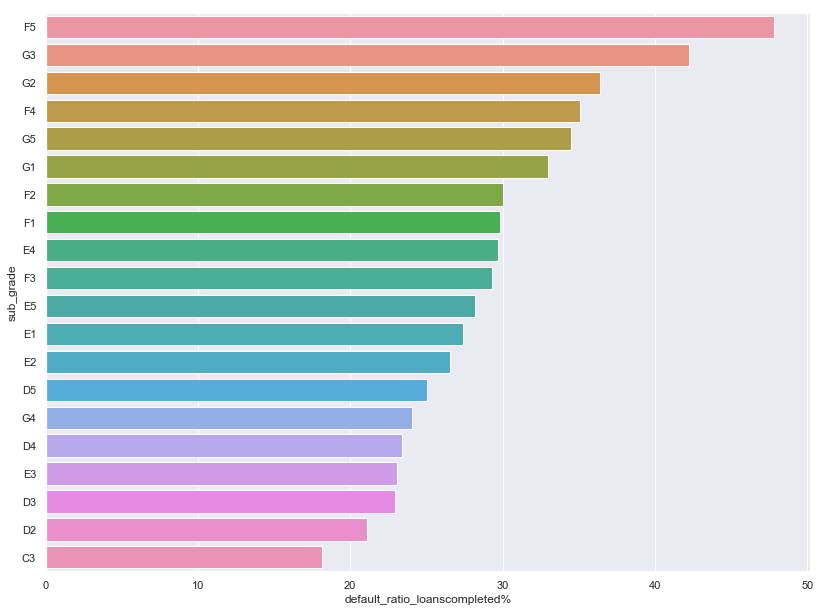

In [67]:
df_to_use =loans_ordinal_pivot_df_arr['sub_grade'].head(20)
ax = sns.barplot(y=df_to_use.index, x="default_ratio_loanscompleted%", data=df_to_use)

### Interval Variable Analysis

In [19]:
##Let's check if zip code affects loan default

In [20]:
zipcode_pivot_df =loans_df.pivot_table(index='zip_code',columns='loan_status', values='id',aggfunc='count',fill_value=0)

In [21]:
zipcode_pivot_df['default_ratio_loanscompleted%'] = (zipcode_pivot_df['Charged Off']/(zipcode_pivot_df['Fully Paid']+ zipcode_pivot_df['Charged Off']))*100

In [22]:
zipcode_pivot_df.sort_values(by='default_ratio_loanscompleted%', inplace=True, ascending=False)

In [23]:
zipcode_pivot_df['total_loans_completed'] =zipcode_pivot_df['Fully Paid']+ zipcode_pivot_df['Charged Off']

In [24]:
zipcode_pivot_df.loc[(zipcode_pivot_df['default_ratio_loanscompleted%'] > 70) & (zipcode_pivot_df.total_loans_completed>5)]

loan_status,Charged Off,Current,Fully Paid,default_ratio_loanscompleted%,total_loans_completed
zip_code,,,,,
561xx,5,0,2,71.428571,7
746xx,5,0,2,71.428571,7


In [ ]:
#TODO 
#1 ) Linear Discriminate Analysis
# 